<a href="https://colab.research.google.com/github/Madhumitha0306/Data_Science_Project/blob/main/Level_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TABLE BOOKING AND ONLINE DELIVERY**

In [1]:
# import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set(style="whitegrid")


In [2]:
# upload the dataset
from google.colab import files
uploaded = files.upload()

Saving Dataset .csv to Dataset .csv


In [4]:
df = pd.read_csv("Dataset .csv")
df.shape, df.columns.tolist()

((9551, 21),
 ['Restaurant ID',
  'Restaurant Name',
  'Country Code',
  'City',
  'Address',
  'Locality',
  'Locality Verbose',
  'Longitude',
  'Latitude',
  'Cuisines',
  'Average Cost for two',
  'Currency',
  'Has Table booking',
  'Has Online delivery',
  'Is delivering now',
  'Switch to order menu',
  'Price range',
  'Aggregate rating',
  'Rating color',
  'Rating text',
  'Votes'])

In [12]:

# Columns: 'Has Table booking', 'Has Online delivery'
def conv_bool(x):
    if pd.isna(x): return np.nan
    if isinstance(x, (int, float)) and not isinstance(x, bool):
        if x == 1: return True
        if x == 0: return False
    s = str(x).strip().lower()
    if s in ("yes","y","true","t","1","available"): return True
    if s in ("no","n","false","f","0","not available"): return False
    return np.nan

df["_table_booking_bool"] = df["Has Table booking"].map(conv_bool)
df["_online_delivery_bool"] = df["Has Online delivery"].map(conv_bool)

print("Table booking known:", df["_table_booking_bool"].notna().sum(),
      "| True:", int(df["_table_booking_bool"].sum(skipna=True)))
print("Online delivery known:", df["_online_delivery_bool"].notna().sum(),
      "| True:", int(df["_online_delivery_bool"].sum(skipna=True)))


Table booking known: 9551 | True: 1158
Online delivery known: 9551 | True: 2451


In [13]:

# Column: 'Aggregate rating'
# Often already numeric; try coercion then a simple extractor if necessary
def extract_num(x):
    if pd.isna(x): return np.nan
    import re
    m = re.search(r"\d+(\.\d+)?", str(x))
    return float(m.group(0)) if m else np.nan

df["_rating_num"] = pd.to_numeric(df["Aggregate rating"], errors="coerce")
mask = df["_rating_num"].isna()
if mask.any():
    df.loc[mask, "_rating_num"] = df.loc[mask, "Aggregate rating"].apply(extract_num)

df["_rating_num"].describe()


,_rating_num
count,9551.000000
mean,2.666370
std,1.516378
min,0.000000
25%,2.500000
50%,3.200000
75%,3.700000
max,4.900000


In [14]:

# Column: 'Price range' (Zomato-like values usually 1-4)
s = df["Price range"]

if pd.api.types.is_numeric_dtype(s):
    # map 1->Low, 2->Medium, 3->High, 4->Very High (adjust if your values differ)
    mapping = {1: "Low", 2: "Medium", 3: "High", 4: "Very High"}
    df["_price_bucket"] = s.map(mapping).fillna("Unknown")
else:
    # fallback textual mapping
    def txt(x):
        if pd.isna(x): return np.nan
        x = str(x).strip().lower()
        if x in ("1","low","$"): return "Low"
        if x in ("2","medium","$$"): return "Medium"
        if x in ("3","high","$$$"): return "High"
        if x in ("4","very high","$$$$"): return "Very High"
        return "Unknown"
    df["_price_bucket"] = s.apply(txt)

df["_price_bucket"].value_counts(dropna=False)


,count
_price_bucket,
Low,4444
Medium,3113
High,1408
Very High,586


In [15]:
# percentage
n_total = len(df)

n_table_known = df["_table_booking_bool"].notna().sum()
n_table_true = int(df["_table_booking_bool"].sum(skipna=True)) if n_table_known>0 else 0
pct_table = n_table_true / n_table_known * 100 if n_table_known>0 else np.nan

n_online_known = df["_online_delivery_bool"].notna().sum()
n_online_true = int(df["_online_delivery_bool"].sum(skipna=True)) if n_online_known>0 else 0
pct_online = n_online_true / n_online_known * 100 if n_online_known>0 else np.nan

print(f"Total restaurants: {n_total}")
print(f"Table booking known: {n_table_known}, available: {n_table_true} -> {pct_table:.2f}%")
print(f"Online delivery known: {n_online_known}, available: {n_online_true} -> {pct_online:.2f}%")


Total restaurants: 9551
Table booking known: 9551, available: 1158 -> 12.12%
Online delivery known: 9551, available: 2451 -> 25.66%


In [16]:
# Compare average ratings: table booking vs not (summary + t-test)
sub = df[df["_rating_num"].notna() & df["_table_booking_bool"].notna()].copy()
summary = sub.groupby("_table_booking_bool")["_rating_num"].agg(["count","mean","std"]).reset_index()
print("Rating summary by table booking availability:")
print(summary)

true_r = sub[sub["_table_booking_bool"]==True]["_rating_num"]
false_r = sub[sub["_table_booking_bool"]==False]["_rating_num"]
if len(true_r)>=2 and len(false_r)>=2:
    t_stat, p_val = stats.ttest_ind(true_r, false_r, equal_var=False, nan_policy="omit")
    print(f"\nWelch t-test: t={t_stat:.4f}, p={p_val:.4f}")
else:
    print("\nNot enough data to run t-test (need >=2 in both groups).")


Rating summary by table booking availability:
   _table_booking_bool  count      mean       std
0                False   8393  2.559359  1.554075
1                 True   1158  3.441969  0.881305

Welch t-test: t=28.5087, p=0.0000


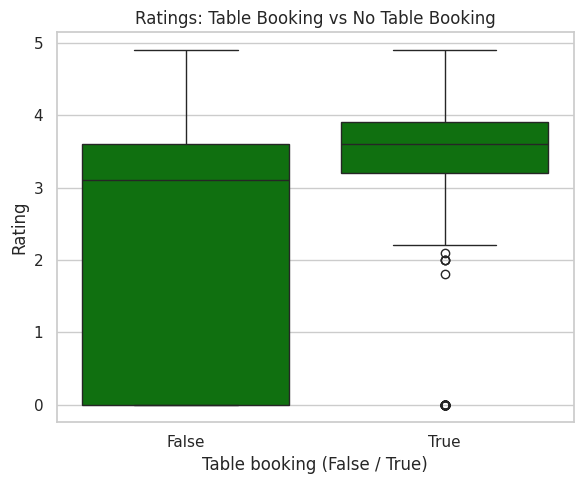

In [29]:
# box plot
plt.figure(figsize=(6,5))
plot_df = df[df["_rating_num"].notna() & df["_table_booking_bool"].notna()]
if plot_df.empty:
    print("No data to plot (ratings or table booking info missing).")
else:
    sns.boxplot(x="_table_booking_bool", y="_rating_num", data=plot_df,color='green')
    plt.xlabel("Table booking (False / True)")
    plt.ylabel("Rating")
    plt.title("Ratings: Table Booking vs No Table Booking")
    plt.xticks([0,1], ["False","True"])
    plt.tight_layout()
    plt.show()


In [21]:
# Online delivery by price bucket (crosstab + print)
mask = df["_price_bucket"].notna() & df["_online_delivery_bool"].notna()
ct = pd.crosstab(df.loc[mask, "_price_bucket"], df.loc[mask, "_online_delivery_bool"])
ct_pct = pd.crosstab(df.loc[mask, "_price_bucket"], df.loc[mask, "_online_delivery_bool"], normalize="index")*100

print("Counts (price bucket vs online delivery):")
print(ct)
print("\nPercent (row-wise):")
print(ct_pct.round(2))


Counts (price bucket vs online delivery):
_online_delivery_bool  False  True 
_price_bucket                      
High                     997    411
Low                     3743    701
Medium                  1827   1286
Very High                533     53

Percent (row-wise):
_online_delivery_bool  False  True 
_price_bucket                      
High                   70.81  29.19
Low                    84.23  15.77
Medium                 58.69  41.31
Very High              90.96   9.04


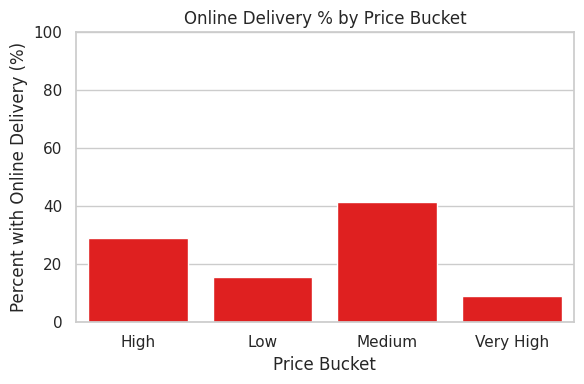

In [27]:
# bar plot
if True in ct_pct.columns:
    plot_df = ct_pct.reset_index()
    plt.figure(figsize=(6,4))
    sns.barplot(x="_price_bucket", y=True, data=plot_df,color='red')
    plt.ylabel("Percent with Online Delivery (%)")
    plt.xlabel("Price Bucket")
    plt.ylim(0,100)
    plt.title("Online Delivery % by Price Bucket")
    plt.tight_layout()
    plt.show()
else:
    print("No True column in contingency percent — maybe no online delivery True values present.")


In [28]:
# Chi-square test for association (price bucket vs online delivery)
ct_for_test = pd.crosstab(df.loc[mask, "_price_bucket"], df.loc[mask, "_online_delivery_bool"])
if ct_for_test.shape[0] >= 2 and ct_for_test.shape[1] == 2:
    chi2, p, dof, expected = stats.chi2_contingency(ct_for_test)
    print(f"Chi-square: chi2={chi2:.4f}, p={p:.4f}, dof={dof}")
else:
    print("Chi-square not run: need >=2 price buckets and exactly 2 online_delivery categories (True/False).")


Chi-square: chi2=721.3787, p=0.0000, dof=3


**PRICE RANGE ANALYSIS**

In [30]:
# Find which price range appears most
most_common_price = df["Price range"].mode()[0]
print("Most common price range:", most_common_price)

# Display count of each price range
df["Price range"].value_counts()


Most common price range: 1


,count
Price range,
1,4444
2,3113
3,1408
4,586


In [31]:
# Group by price range and calculate mean rating
avg_rating_by_price = df.groupby("Price range")["Aggregate rating"].mean().reset_index()

# Rename columns for clarity
avg_rating_by_price.columns = ["Price Range", "Average Rating"]

# Display result
avg_rating_by_price


,Price Range,Average Rating
0,1,1.999887
1,2,2.941054
2,3,3.683381
3,4,3.817918


In [32]:
# Group by rating color and find average rating
avg_rating_by_color = df.groupby("Rating color")["Aggregate rating"].mean().reset_index()

# Sort descending to find highest
highest_color = avg_rating_by_color.sort_values(by="Aggregate rating", ascending=False).iloc[0]

print("Color with highest average rating:")
print(highest_color)


Color with highest average rating:
Rating color        Dark Green
Aggregate rating      4.659801
Name: 0, dtype: object


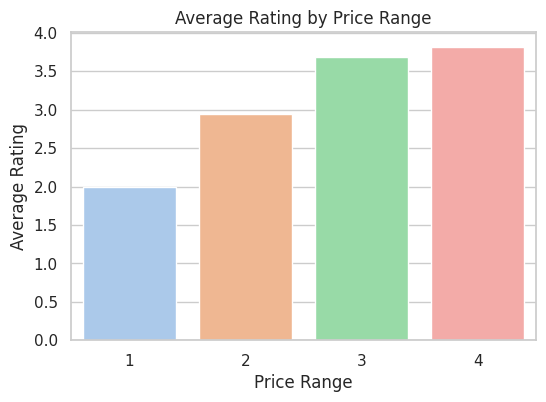

In [34]:

# Barplot of average rating by price range
plt.figure(figsize=(6,4))
sns.barplot(x="Price Range", y="Average Rating", data=avg_rating_by_price, hue="Price Range", palette="pastel", legend=False)
plt.title("Average Rating by Price Range")
plt.show()


**FEATURE ENGINEERING**

In [35]:
# Create new columns for text lengths
df["Restaurant Name Length"] = df["Restaurant Name"].astype(str).apply(len)
df["Address Length"] = df["Address"].astype(str).apply(len)

# Show first few rows to verify
df[["Restaurant Name", "Restaurant Name Length", "Address", "Address Length"]].head()


,Restaurant Name,Restaurant Name Length,Address,Address Length
0,Le Petit Souffle,16,"Third Floor, Century City Mall, Kalayaan Avenu...",71
1,Izakaya Kikufuji,16,"Little Tokyo, 2277 Chino Roces Avenue, Legaspi...",67
2,Heat - Edsa Shangri-La,22,"Edsa Shangri-La, 1 Garden Way, Ortigas, Mandal...",56
3,Ooma,4,"Third Floor, Mega Fashion Hall, SM Megamall, O...",70
4,Sambo Kojin,11,"Third Floor, Mega Atrium, SM Megamall, Ortigas...",64


In [37]:
# Encode “Has Table booking” and “Has Online delivery” columns
# Convert 'Yes'/'No' to 1 and 0
df["Has Table Booking (Encoded)"] = df["Has Table booking"].apply(lambda x: 1 if str(x).lower() == "yes" else 0)
df["Has Online Delivery (Encoded)"] = df["Has Online delivery"].apply(lambda x: 1 if str(x).lower() == "yes" else 0)

# Check first few rows
df[["Has Table booking", "Has Table Booking (Encoded)",
    "Has Online delivery", "Has Online Delivery (Encoded)"]].head()


,Has Table booking,Has Table Booking (Encoded),Has Online delivery,Has Online Delivery (Encoded)
0,Yes,1,No,0
1,Yes,1,No,0
2,Yes,1,No,0
3,No,0,No,0
4,Yes,1,No,0


In [38]:
# Select relevant numeric columns
num_cols = ["Restaurant Name Length", "Address Length",
            "Has Table Booking (Encoded)", "Has Online Delivery (Encoded)", "Aggregate rating"]

# Compute correlation
corr = df[num_cols].corr()

# Display correlation table
print(corr)


                               Restaurant Name Length  Address Length  \
Restaurant Name Length                       1.000000        0.009567   
Address Length                               0.009567        1.000000   
Has Table Booking (Encoded)                  0.075672        0.064177   
Has Online Delivery (Encoded)               -0.159614       -0.018362   
Aggregate rating                            -0.035178        0.002334   

                               Has Table Booking (Encoded)  \
Restaurant Name Length                            0.075672   
Address Length                                    0.064177   
Has Table Booking (Encoded)                       1.000000   
Has Online Delivery (Encoded)                     0.101224   
Aggregate rating                                  0.189998   

                               Has Online Delivery (Encoded)  Aggregate rating  
Restaurant Name Length                             -0.159614         -0.035178  
Address Length            

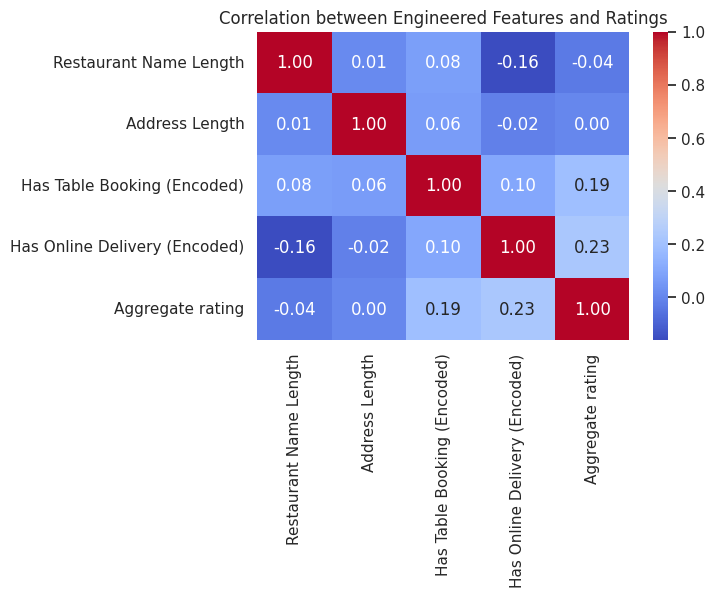

In [40]:
# Visualize correlation heatmap
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation between Engineered Features and Ratings")
plt.show()
